# Imports

In [1]:
%matplotlib inline

from numpy.random import randint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.initializers import  HeNormal
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
  Input, Conv2D, Conv2DTranspose, LeakyReLU, MaxPooling2D, Flatten, Dense, Dropout,
  Activation, Concatenate, BatchNormalization, ZeroPadding2D
)
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import os
from tensorflow.keras.models import Model
from tqdm.notebook import tqdm
from skimage.color import rgb2lab, lab2rgb
import os


In [2]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

config = tf.compat.v1.ConfigProto(
  gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

# Constants

In [3]:
pos_threshold = 0.5
neg_threshold = 0.1
iou_threshold = 0.5
grid_width = 16
grid_height = 16
image_width = 640
image_height = 480
buffer_size=1000
batch_size = 1
n_classes = 3

label_dir = "dataset/test.csv"
dataset_dir = "dataset/BCCD"
n_grids_x = int(image_width / grid_width)
n_grids_y = int(image_height / grid_height)
print(n_grids_x)
print(n_grids_y)


40
30


In [4]:
wandhG = np.array([[100.0, 100.0], [300.0, 300.0], [500.0, 500.0],
                   [200.0, 100.0], [370.0, 185.0], [440.0, 220.0],
                   [100.0, 200.0], [185.0, 370.0], [220.0, 440.0]])

# Helper Functions

## turn_mask_into_indexes

In [5]:
def turn_mask_into_indexes(mask):
  zipped_indexes = tf.experimental.numpy.nonzero(mask)
  n_dim = len(zipped_indexes)
  n_coordinates = len(zipped_indexes[0])
  
  return [[int(zipped_indexes[d][idx]) for d in range(n_dim)] for idx in range(n_coordinates)]

## compute_iou

In [6]:
def compute_iou(boxes1, boxes2):
    """(xmin, ymin, xmax, ymax, type_index)
    boxes1 shape:  [-1, 4], boxes2 shape: [-1, 4]
    """
    left_up = np.maximum(boxes1[..., :2], boxes2[..., :2], )
    right_down = np.minimum(boxes1[..., 2:], boxes2[..., 2:])
    inter_wh = np.maximum(right_down - left_up, 0.0)
    inter_area = inter_wh[..., 0] * inter_wh[..., 1]

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    union_area = boxes1_area + boxes2_area - inter_area
    ious = inter_area / union_area
    return ious

## plot_boxes_on_image

In [7]:
def plot_boxes_on_image(show_image_with_boxes, boxes, cls_scores=None, color=[0, 0, 255], thickness=2, with_classifcation=False):
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 0.4
  color = (255, 255, 255)
  thickness = 1
  scores = [0] * len(boxes)
  
  try:
    if cls_scores is not None and with_classifcation:
      class_idxes = np.argmax(cls_scores, axis=-1)
      classes = [types[class_idx] for class_idx in class_idxes]
      scores = np.max(cls_scores, axis=-1)
  except Exception:
    with_classifcation = False
  
  for idx, box in enumerate(boxes):    
    cv2.rectangle(show_image_with_boxes,
            pt1=(int(box[0]), int(box[1])),
            pt2=(int(box[2]), int(box[3])), color=color, thickness=thickness)

    if with_classifcation:
      score = scores[idx]
      class_ = classes[idx]
      cv2.putText(
        show_image_with_boxes, 
        "{}-{:.2f}".format(class_, score), 
        (int(box[0])+5, int(box[1])+15), 
        font, 
        font_scale, 
        color, 
        thickness, 
        cv2.LINE_AA
      )
  
  return

## load_gt_boxes

In [8]:
bbs = open(label_dir).readlines()[1:]
bbs = [bb.replace("\n", "").split(",") for bb in bbs]
bbs_dict = {}
#[['BloodImage_00000.jpg', 'WBC', '260', '491', '177', '376']]

types = set()
for bb in bbs:
  _, cls, _, _, _, _ =  bb
  types.add(cls)
  
types = ["other"] + list(types)

for bb in bbs:
  filename, cls, xmin, xmax, ymin, ymax =  bb
  if filename not in bbs_dict:
    bbs_dict[filename] = [(xmin, ymin, xmax, ymax, types.index(cls))]
  else: 
    bbs_dict[filename].append((xmin, ymin, xmax, ymax, types.index(cls)))

In [9]:
def load_gt_boxes(filename=None):
    """
    xmin, ymin, xmax, ymax
    """
    roi = np.zeros(shape=(len(bbs), 4))
    gt_classes = []
    idx = 0
    if filename is not None and (filename in bbs_dict):
      boxes = bbs_dict[filename]
      for box_data in boxes:
        roi[idx] = box_data[0:4]
        gt_classes.append(box_data[4])
        idx += 1
    return np.array(roi), gt_classes

## compute_regression

In [10]:
def compute_regression(box1, box2):
    """
    box1: ground-truth boxes
    box2: anchor boxes
    """
    target_reg = np.zeros(shape=[4,])
    w1 = box1[2] - box1[0]
    h1 = box1[3] - box1[1]
    w2 = box2[2] - box2[0]
    h2 = box2[3] - box2[1]

    target_reg[0] = (box1[0] - box2[0]) / w2
    target_reg[1] = (box1[1] - box2[1]) / h2
    target_reg[2] = np.log(w1 / w2)
    target_reg[3] = np.log(h1 / h2)

    return target_reg

## decode_output

In [11]:
def decode_output(pred_bboxes, pred_scores, score_thresh=0.5):
    """
    pred_bboxes shape: [1, 45, 60, 9, 4]
    pred_scores shape: [1, 45, 60, 9, 2]
    """
    grid_x, grid_y = tf.range(n_grids_x, dtype=tf.int64), tf.range(n_grids_y, dtype=tf.int64)
    grid_x, grid_y = tf.meshgrid(grid_x, grid_y)
    grid_x, grid_y = tf.expand_dims(grid_x, -1), tf.expand_dims(grid_y, -1)
    grid_xy = tf.stack([grid_x, grid_y], axis=-1)
    center_xy = grid_xy * grid_width + grid_width//2
    center_xy = tf.cast(center_xy, tf.float32)
    anchor_xymin = center_xy - 0.5 * wandhG

    xy_min = pred_bboxes[..., 0:2] * wandhG[:, 0:2] + anchor_xymin
    xy_max = tf.exp(pred_bboxes[..., 2:4]) * wandhG[:, 0:2] + xy_min

    pred_bboxes = tf.concat([xy_min, xy_max], axis=-1)
    pred_scores = pred_scores[..., 1]
    score_mask = pred_scores > score_thresh
    pred_bboxes_ = tf.reshape(pred_bboxes[score_mask], shape=[-1,4]).numpy()
    pred_scores_ = tf.reshape(pred_scores[score_mask], shape=[-1,]).numpy()
    return pred_bboxes_, pred_scores_, score_mask

## nms

In [12]:
def nms(pred_boxes, pred_score, iou_thresh=iou_threshold, cls_scores=None):
    """
    pred_boxes shape: [-1, 4]
    pred_score shape: [-1,]
    """
    selected_boxes = []
    selected_cls_scores = []
          
    while len(pred_boxes) > 0:
      max_idx = np.argmax(pred_score)
      selected_box = pred_boxes[max_idx]
      
      if cls_scores is not None:
        selected_cls_score = cls_scores[max_idx]
        
      
      selected_boxes.append(selected_box)
      
      if cls_scores is not None:
        selected_cls_scores.append(selected_cls_score)
      
      pred_boxes = np.concatenate([pred_boxes[:max_idx], pred_boxes[max_idx+1:]])
      pred_score = np.concatenate([pred_score[:max_idx], pred_score[max_idx+1:]])
      
      if cls_scores is not None:
        cls_scores = np.concatenate([cls_scores[:max_idx], cls_scores[max_idx+1:]])
      
      ious = compute_iou(selected_box, pred_boxes)
      iou_mask = ious <= 0.1
      
      pred_boxes = pred_boxes[iou_mask]
      pred_score = pred_score[iou_mask]
      
      if cls_scores is not None:
        cls_scores = cls_scores[iou_mask]

    selected_boxes = np.array(selected_boxes)
    selected_cls_scores = np.array(selected_cls_scores)
    
    return selected_boxes, selected_cls_scores

# Model Definition

## get_feature_gen

In [ ]:
# We use feature pyramid by concantenation instead of addition

def get_feature_gen():
  input = Input((image_height,image_width,3))
  x = Conv2D(64, 3, activation="relu", padding="same")(input)
  x = Conv2D(64, 3, activation='relu', padding='same')(x)
  x = MaxPooling2D(2, strides=2, padding='same')(x)

  # 2nd
  x = Conv2D(128, 3, activation='relu', padding='same')(x)
  x = Conv2D(128, 3, activation='relu', padding='same')(x)
  x = MaxPooling2D(2, strides=2, padding='same')(x)

  # 3rd
  x = Conv2D(256, 3, activation='relu', padding='same')(x)
  x = Conv2D(256, 3, activation='relu', padding='same')(x)
  x = Conv2D(256, 3, activation='relu', padding='same')(x)
  x = MaxPooling2D(2, strides=2, padding='same')(x)
  
  pool3_p = MaxPooling2D(2, strides=2, padding='same')(x)
  pool3_p = Conv2D(256, kernel_size=[5,2], activation="relu", padding='same', use_bias=False)(pool3_p)
  
  # 4th
  x = Conv2D(512, 3, activation='relu', padding='same')(x)
  x = Conv2D(512, 3, activation='relu', padding='same')(x)
  x = Conv2D(512, 3, activation='relu', padding='same')(x)
  x = MaxPooling2D(2, strides=2, padding='same')(x)
  pool4_p = Conv2D(512, kernel_size=[5,2], activation="relu", padding='same', use_bias=False)(x)
  
  # 5th
  x = Conv2D(512, 3, activation='relu', padding='same')(x)
  x = Conv2D(512, 3, activation='relu', padding='same')(x)
  x = Conv2D(512, 3, activation='relu', padding='same')(x)
  pool5_p = Conv2D(512, kernel_size=[5,2], activation="relu", padding='same', use_bias=False)(x)
  
  feature = tf.concat([pool3_p, pool4_p, pool5_p], axis=-1)
  #   shape (-1, height/16, widht/16, 512)
  return Model(input, feature)

## get_RPN

In [14]:
def get_RPN():
  feature = Input(shape=(n_grids_y, n_grids_x, 1280))
  #   spatial dimension = original / 16
  #   conv feature to get desired number of filters that match 9*2 and 9*4
  #   they are to be reshaped
  conv_cls_scores = Conv2D(18, kernel_size=1, padding='same', use_bias=False)(feature)
  conv_cls_bboxes = Conv2D(36, kernel_size=1, padding='same', use_bias=False, activation="linear")(feature)
  
  cls_scores = tf.reshape(conv_cls_scores, (-1, n_grids_y, n_grids_x, 9, 2))
  cls_bboxes = tf.reshape(conv_cls_bboxes, (-1, n_grids_y, n_grids_x, 9, 4))                    
    
  model = Model(feature, [cls_scores, cls_bboxes])
  return model

## roi_pooling

In [15]:
permutation_matrix = np.zeros((4,4)) # [x1,y1,x2,y2] -> [y1,x1, y2,x2]
permutation_matrix[1,0] = 1
permutation_matrix[0,1] = 1
permutation_matrix[2,3] = 1
permutation_matrix[3,2] = 1
permutation_matrix = tf.transpose(tf.convert_to_tensor(permutation_matrix, dtype=tf.float32))

In [16]:
def roi_pooling(feature, roi_boxes, pool_size=7):
  input_features = feature
  batches = tf.shape(roi_boxes)[0]
  input_boxes = roi_boxes
  
  features = input_features
  boxes = input_boxes
  n_boxes = tf.shape(boxes)[0]
  pooling_boxes = tf.reshape(boxes, (-1, 4))
  pooling_bbox_indices = tf.tile(tf.expand_dims(tf.range(batch_size), axis=1), (1, n_boxes))
  pooling_bbox_indices = tf.reshape(pooling_bbox_indices, (-1, ))
  
  scale = tf.constant([[1/(16*n_grids_x), 1/(16*n_grids_y), 1/(16*n_grids_x), 1/(16*n_grids_y)]], dtype=tf.float32)
  pooling_boxes = pooling_boxes * scale
  #  permute (xmin, ymin, xmax, ymax) to (ymin, xmin, ymax, xmax)
  pooling_boxes = tf.linalg.matmul(pooling_boxes, permutation_matrix)
  pooling_feature_map = tf.image.crop_and_resize(
    features,
    pooling_boxes,
    pooling_bbox_indices,
    (pool_size, pool_size)
  )
  
  return pooling_feature_map # (-1, 7, 7, 1280)

## get_DetectionLayer

In [17]:
# def get_DetectionLayer():
#   input_ = Input(shape=(7, 7, 1280))
#   output = Conv2D(4096, (7,7))(input_)
#   output = BatchNormalization()(output)
#   output = Activation("relu")(output)
  
#   output = Conv2D(4096, (1,1))(output)
#   output = BatchNormalization()(output)
#   output = Activation("relu")(output)
  
#   output = Flatten()(output)
#   output = Dropout(0.5)(output)
  
#   cls_predictions = Dense(len(types), activation="softmax")(output)
#   adjusted_boxes_predictions = Dense(4, activation="relu")(output)
  
#   return Model(input_, [cls_predictions, adjusted_boxes_predictions])

def get_DetectionLayer():
  input_ = Input(shape=(7, 7, 1280))
  output = Flatten()(input_)
  output = Dense(4096, activation="relu")(output)
  output = Dropout(0.5)(output)
  cls_predictions = Dense(len(types), activation="softmax")(output)
  boxes_predictions = Dense(4, activation="relu")(output)
  
  return Model(input_, [cls_predictions, boxes_predictions])

## get_MaskPredictionLayer

In [18]:
def get_MaskPredictionLayer():
  input_ = Input(shape=(14, 14, 1280))
  x = Conv2D(256, (3,3))(input_)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  
  x = Conv2D(256, (3,3))(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)  

  x = Conv2D(256, (3,3))(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)  
  
  x = Conv2D(256, (3,3))(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)  
  
  x = Conv2DTranspose(256, (2,2), strides=2, activation="relu")(x) # (-1, 28, 28, 256)
  x = Conv2DTranspose(len(types), (1,1), strides=2, activation="relu")(x) # (-1, 28, 28, 4)

# Dataset Pipeline

## encode_label

In [19]:
def encode_label(gt_boxes, gt_type_indexes):
  target_fgbg_scores = np.zeros(shape=[n_grids_y, n_grids_x, 9, 2]) # 0: background, 1: foreground, ,
  target_bboxes = np.zeros(shape=[n_grids_y, n_grids_x, 9, 4]) # t_x, t_y, t_w, t_h
  #   target_masks is used to calculate background or foreground, should be used by the RPN layer only.
  target_masks  = np.zeros(shape=[n_grids_y, n_grids_x, 9]) # negative_samples: -1, positive_samples: 1
  target_class_indexes = np.zeros(shape=[n_grids_y, n_grids_x, 9, len(types)]) # class index
  
  for i in range(n_grids_y): # y: height
    for j in range(n_grids_x): # x: width
      for k in range(9):
        target_class_indexes[i, j, k, 0] = 1
        
        center_x = j * grid_width + grid_width * 0.5
        center_y = i * grid_height + grid_height * 0.5
        xmin = center_x - wandhG[k][0] * 0.5
        ymin = center_y - wandhG[k][1] * 0.5
        xmax = center_x + wandhG[k][0] * 0.5
        ymax = center_y + wandhG[k][1] * 0.5

        if (xmin > -5) & (ymin > -5) & (xmax < (image_width+5)) & (ymax < (image_height+5)):
          anchor_boxes = np.array([xmin, ymin, xmax, ymax])
          anchor_boxes = np.expand_dims(anchor_boxes, axis=0)
          ious = compute_iou(anchor_boxes, gt_boxes)
          positive_masks = ious >= pos_threshold
          negative_masks = ious <= neg_threshold

          if np.any(positive_masks):
            target_fgbg_scores[i, j, k, 1] = 1.
            target_masks[i, j, k] = 1 # labeled as a positive sample
            # find out which ground-truth box matches this anchor
            max_iou_idx = np.argmax(ious)
            selected_gt_boxes = gt_boxes[max_iou_idx]
            selected_gt_class_indexes = int(gt_type_indexes[max_iou_idx])
            
            target_bboxes[i, j, k] = compute_regression(selected_gt_boxes, anchor_boxes[0])
            target_class_indexes[i, j, k, 0] = 0
            target_class_indexes[i, j, k, selected_gt_class_indexes] = 1

          if np.all(negative_masks):
            target_fgbg_scores[i, j, k, 0] = 1.
            target_masks[i, j, k] = -1 # labeled as a negative sample

  # per grid per anchor :
  
  return tf.convert_to_tensor(target_fgbg_scores, dtype=tf.float32), \
          tf.convert_to_tensor(target_bboxes, dtype=tf.float32), \
          tf.convert_to_tensor(target_masks, dtype=tf.float32), \
          tf.convert_to_tensor(target_class_indexes, dtype=tf.float32)

In [20]:
def get_img_and_gtboxes(img_path):
  img_path = bytes.decode(img_path)
  img = tf.io.read_file(img_path)
  img = tf.cast(tf.io.decode_jpeg(img), dtype=tf.float32)/255.0
  filename = os.path.basename(img_path)
  gt_boxes, gt_type_indexes = load_gt_boxes(filename=filename)
  gt_boxes = tf.convert_to_tensor(gt_boxes, dtype=tf.float32) 
  gt_type_indexes = tf.convert_to_tensor(gt_type_indexes, dtype=tf.float32)
  return img, gt_boxes, gt_type_indexes

def process_imgpath(img_path):
  img, gt_boxes, gt_type_indexes = tf.numpy_function(func=get_img_and_gtboxes, inp=[img_path], Tout=[tf.float32, tf.float32, tf.float32])
  target_fgbg_scores, target_bboxes, target_masks, target_class_indexes = tf.numpy_function(func=encode_label, inp=[gt_boxes, gt_type_indexes], Tout=[tf.float32,tf.float32,tf.float32,tf.float32])
  return img, target_fgbg_scores, target_bboxes, target_masks, target_class_indexes

## get_img_targetScores_targetBboxes_targetMasks

In [21]:
import random
from copy import deepcopy
image_paths = deepcopy(list(bbs_dict.keys()))
image_paths = [os.path.join(dataset_dir, path) for path in image_paths]

def get_img_targetScores_targetBboxes_targetMasks():
  dataset = tf.data.Dataset.from_tensor_slices(image_paths)\
              .map(process_imgpath)\
              .batch(batch_size)\
              .shuffle(buffer_size)\
              .cache()
  
  return iter(dataset)

# Init Models

In [22]:
feature_gen = get_feature_gen()
RPN = get_RPN()
detectionLayer = get_DetectionLayer()

feature_gen.load_weights("feature_gen_epoch_10_360.h5")
RPN.load_weights("RPN_epoch_10_360.h5")
# detectionLayer.load_weights("detectionLayer_epoch_6_360.h5")

# Sample Result Function

## compute_bounding_boxes_and_class_scores

In [23]:
grid_x, grid_y = tf.range(n_grids_x, dtype=tf.int64), tf.range(n_grids_y, dtype=tf.int64)
grid_x, grid_y = tf.meshgrid(grid_x, grid_y)
grid_x, grid_y = tf.expand_dims(grid_x, -1), tf.expand_dims(grid_y, -1)
grid_xy = tf.stack([grid_x, grid_y], axis=-1)
center_xy = grid_xy * grid_width + grid_width//2
center_xy = tf.cast(center_xy, tf.float32)

def compute_bounding_boxes_and_class_scores(image_data):
  feature = feature_gen.predict(image_data[np.newaxis,...])
  pred_scores, pred_bboxes = RPN.predict(feature)
  pred_bboxes, pred_scores, score_mask = decode_output(pred_bboxes, pred_scores, score_thresh=0.5)
  pooling_features = roi_pooling(feature, pred_bboxes)
  cls_predictions, adjusted_boxes_predictions = detectionLayer(pooling_features)
  # cls_predictions, boxes_predictions = detectionLayer(pooling_features)

  anchor_xymin = center_xy - 0.5 * wandhG
  
  wandhG_augmented = np.repeat(np.repeat(wandhG[np.newaxis, np.newaxis, ...], n_grids_y, axis=0), n_grids_x, axis=1)[np.newaxis, ...]
  #   The mask will make them into a "list" as a numpy array
  xy_min = adjusted_boxes_predictions[..., 0:2]*wandhG_augmented[score_mask]  + anchor_xymin[np.newaxis, ...][score_mask]
  xy_max = tf.exp(adjusted_boxes_predictions[..., 2:4])*wandhG_augmented[score_mask]  + xy_min
  
  adjusted_pred_bboxes = np.concatenate([xy_min, xy_max], axis=-1)
  
  return pred_bboxes, adjusted_pred_bboxes, pred_scores, cls_predictions

In [31]:
print(tf.cast(center_xy, tf.float32).shape)
print(wandhG.shape)

(30, 40, 1, 2)
(9, 2)


In [28]:
(tf.cast(center_xy, tf.float32)  - 0.5 * wandhG ).shape

TensorShape([30, 40, 9, 2])

In [24]:
wandhG

array([[100., 100.],
       [300., 300.],
       [500., 500.],
       [200., 100.],
       [370., 185.],
       [440., 220.],
       [100., 200.],
       [185., 370.],
       [220., 440.]])

## view_sample_result

<Figure size 576x720 with 0 Axes>

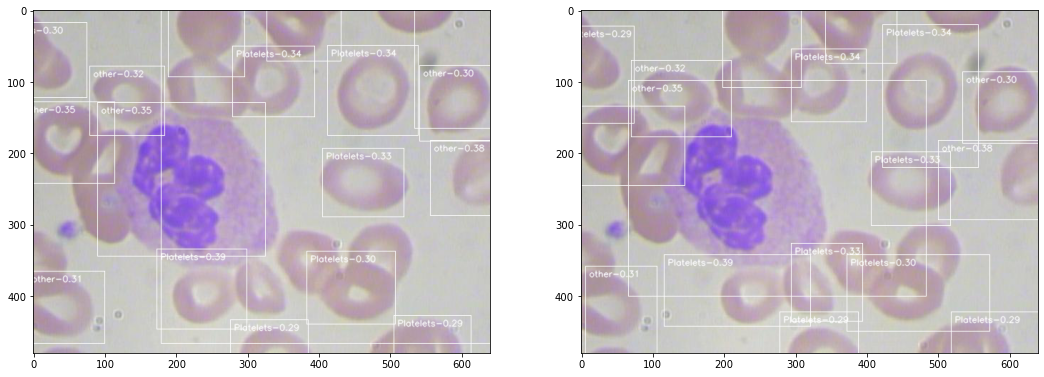

In [25]:
import random
temp_img = None

def view_sample_result( with_classifcation=False):
  global temp_img
  
  cls_predictions = None
  images = os.listdir(dataset_dir)
  random.shuffle(images)
  plt.figure(figsize=(8, 10))
  imgpath = os.path.join(dataset_dir, images[0])
  img = cv2.imread(imgpath)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  image_data = np.copy(img)/255.0
  temp_img = image_data

  pred_bboxes, adjusted_pred_bboxes, pred_scores, cls_predictions_ = compute_bounding_boxes_and_class_scores(image_data)

  if with_classifcation:
    cls_predictions = cls_predictions_  

  plt.figure(figsize=(18, 20))
  for idx, boxes_ in enumerate([pred_bboxes, adjusted_pred_bboxes]):
    try:
      boxes, cls_scores = nms(boxes_, pred_scores, cls_scores=cls_predictions)
    except Exception as err:
      print("error in nms")
      boxes, cls_scores = nms(boxes_, pred_scores, cls_scores=None)

    with_classication = cls_scores is not None
    img_ = np.copy(img)
    plot_boxes_on_image(img_, boxes, cls_scores=cls_scores, with_classifcation=with_classication)

    plt.subplot(1, 2, idx+1)
    # plt.axis("off")
    plt.imshow(img_.astype("uint8"))
  plt.show()

view_sample_result(True)

# Training feature_gen and RPN

In [ ]:
EPOCHS = 10
START_EPOCH = 8


feat_opt = tf.keras.optimizers.Adam(lr=1e-4)
rpn_opt = tf.keras.optimizers.Adam(lr=1e-4)

global_steps = tf.Variable(0, trainable=False, dtype=tf.int64)
writer = tf.summary.create_file_writer("./log")

for epoch in range(EPOCHS):
  batch = 0
  dataset_gen = get_img_targetScores_targetBboxes_targetMasks()
  for data in dataset_gen:
    batch+= 1 
    print(f"batch {batch}", end="\r")
    global_steps.assign_add(1)
    
    # target_fgbg_scores: (..., 2): fg or bg score
    # target_masks: +1 or -1
    image_data, target_fgbg_scores, target_bboxes, target_masks, target_class_indexes = data
    
    with tf.GradientTape(persistent=True) as tape:
      feature = feature_gen(image_data)
      pred_scores, pred_bboxes = RPN(feature)
      
      # score_loss = fg_or_bg_score_loss       
      score_loss = tf.nn.softmax_cross_entropy_with_logits(labels=target_fgbg_scores, logits=pred_scores) 
      foreground_background_mask = tf.cast(tf.math.abs(target_masks) == 1, tf.float32)
      # place to include the loss come from negative sample to further penalize:
      score_loss = tf.reduce_sum(score_loss * foreground_background_mask, axis=[1,2,3]) / tf.reduce_sum(foreground_background_mask)
      score_loss = tf.reduce_mean(score_loss)
      
      foreground_mask = tf.cast(target_masks > 0, tf.float32)
      n_foreground = tf.reduce_sum(foreground_mask)
      
      boxes_loss = 0.
      
      if n_foreground != 0:
        boxes_loss = tf.math.abs(target_bboxes - pred_bboxes)
        boxes_loss = 0.5 * tf.math.pow(boxes_loss, 2) * tf.cast(boxes_loss<1, tf.float32) + (boxes_loss - 0.5) * tf.cast(boxes_loss >=1, tf.float32)
        boxes_loss = tf.reduce_sum(boxes_loss, axis=-1)

        boxes_loss = tf.reduce_sum(boxes_loss * foreground_mask, axis=[1,2,3]) / n_foreground
        boxes_loss = tf.reduce_mean(boxes_loss)  
        if tf.math.is_nan(boxes_loss):
          print("foreground_mask", foreground_mask)
      else:
        print("n_foreground == 0")

      total_loss = score_loss + 1. * boxes_loss     
       
    grad_rpn = tape.gradient(total_loss, RPN.trainable_variables)
    rpn_opt.apply_gradients(zip(grad_rpn, RPN.trainable_variables))
    
    grad_feature_gen = tape.gradient(total_loss, feature_gen.trainable_variables)
    feat_opt.apply_gradients(zip(grad_feature_gen, feature_gen.trainable_variables))
        
    # writing summary data
    with writer.as_default():
      tf.summary.scalar("total_loss", total_loss, step=global_steps)
      tf.summary.scalar("score_loss", score_loss, step=global_steps)
      tf.summary.scalar("boxes_loss", boxes_loss, step=global_steps)
    writer.flush()
    if (batch % 30) == 0:
      print("=> epoch %d  batch %d  total_loss: %.6f  score_loss: %.6f  boxes_loss: %.6f" %(epoch+START_EPOCH, batch+1, total_loss.numpy(), score_loss.numpy(), boxes_loss.numpy()), end="\r")
      view_sample_result(True)
    if batch == 360:
      feature_gen.save_weights(f"feature_gen_epoch_{epoch+START_EPOCH}_{batch}.h5")
      RPN.save_weights(f"RPN_epoch_{epoch+START_EPOCH}_{batch}.h5")

# Train Classifier and Bounding Boxes Adjustment

<Figure size 576x720 with 0 Axes>

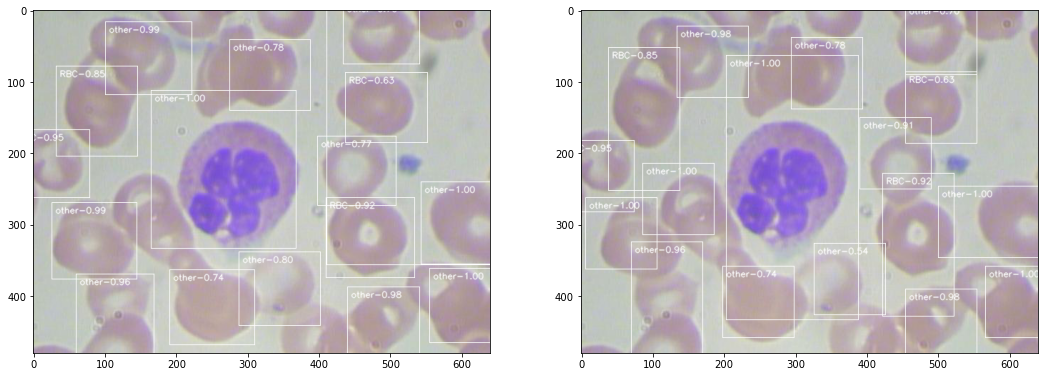

<Figure size 576x720 with 0 Axes>

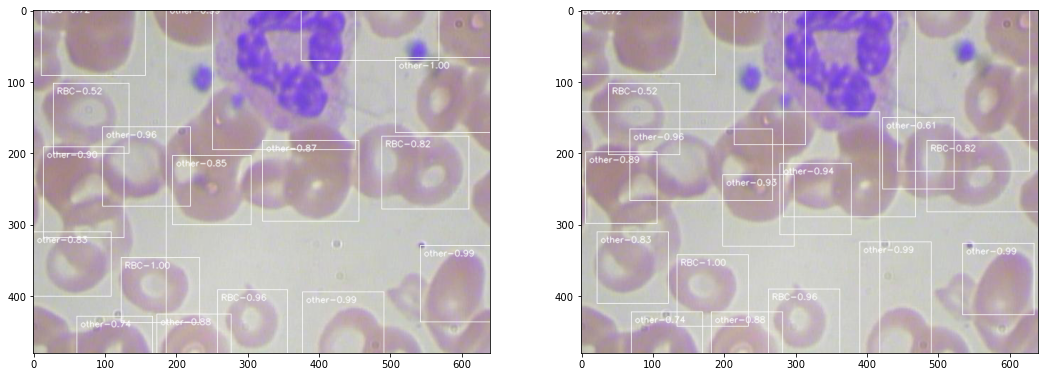

<Figure size 576x720 with 0 Axes>

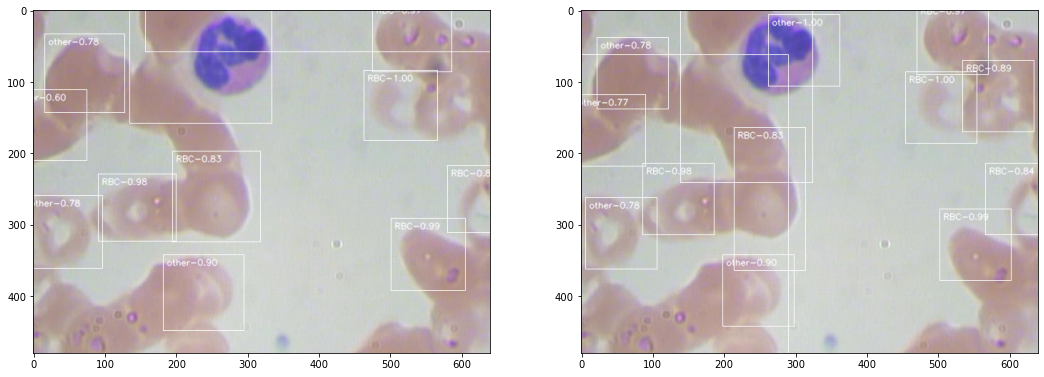

<Figure size 576x720 with 0 Axes>

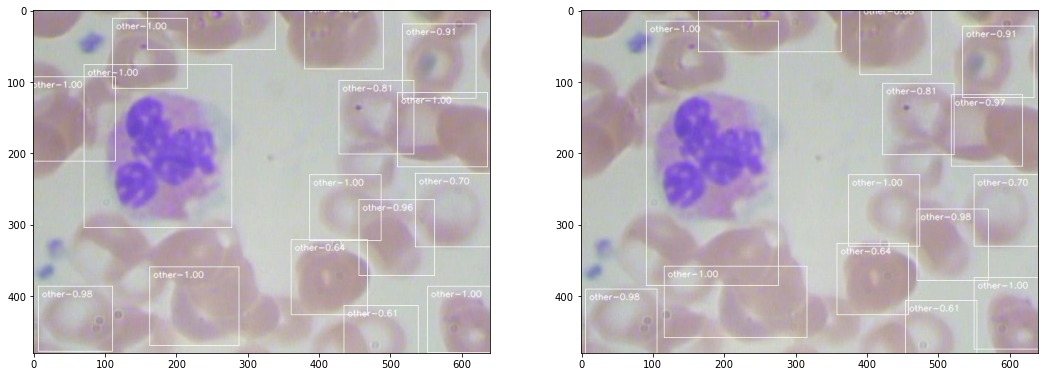

<Figure size 576x720 with 0 Axes>

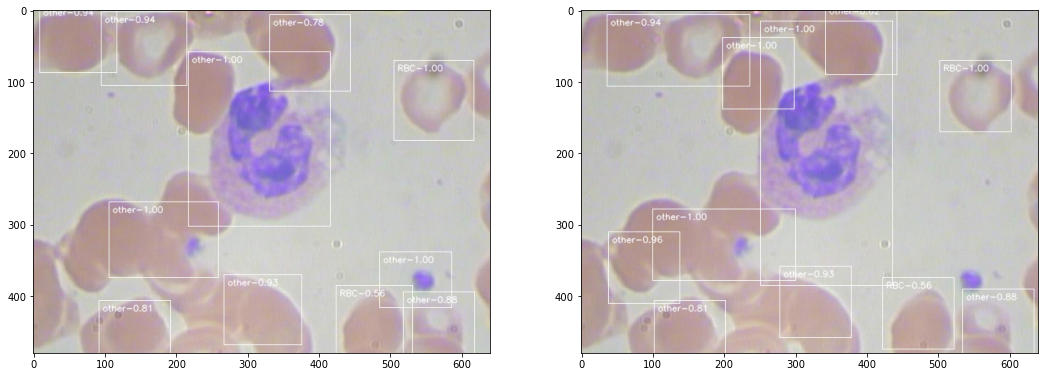

<Figure size 576x720 with 0 Axes>

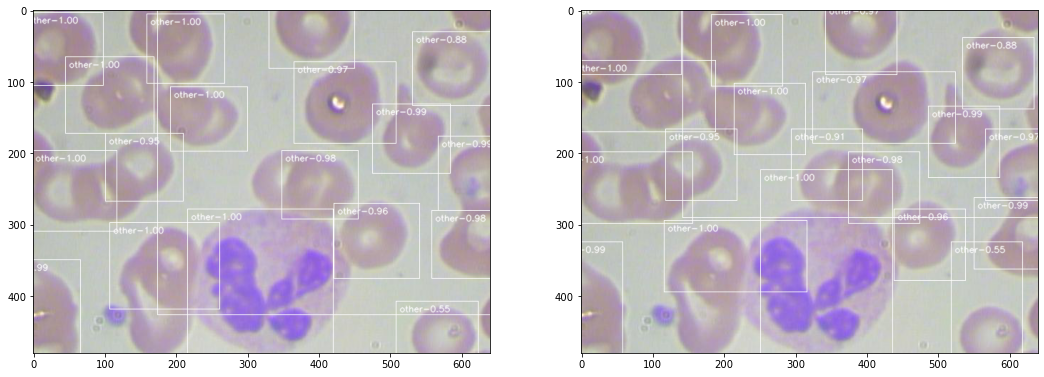

<Figure size 576x720 with 0 Axes>

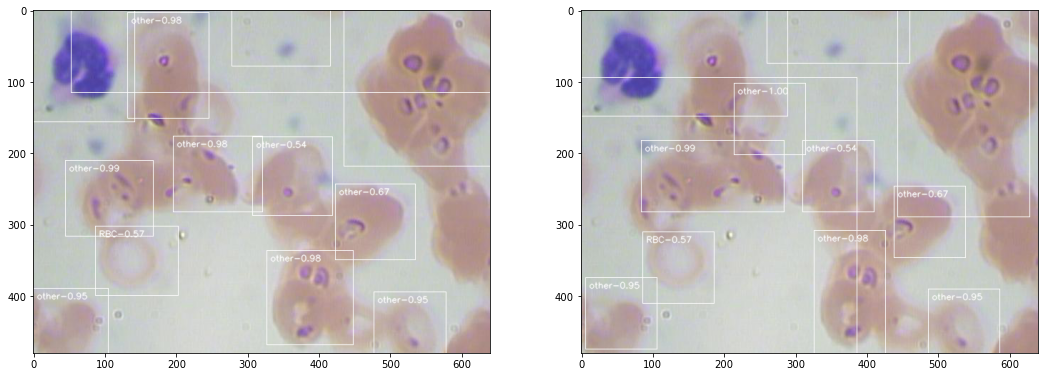

<Figure size 576x720 with 0 Axes>

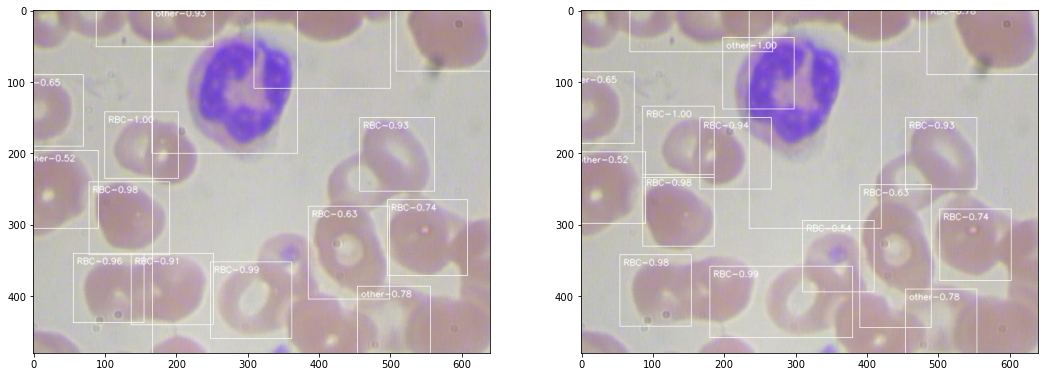

<Figure size 576x720 with 0 Axes>

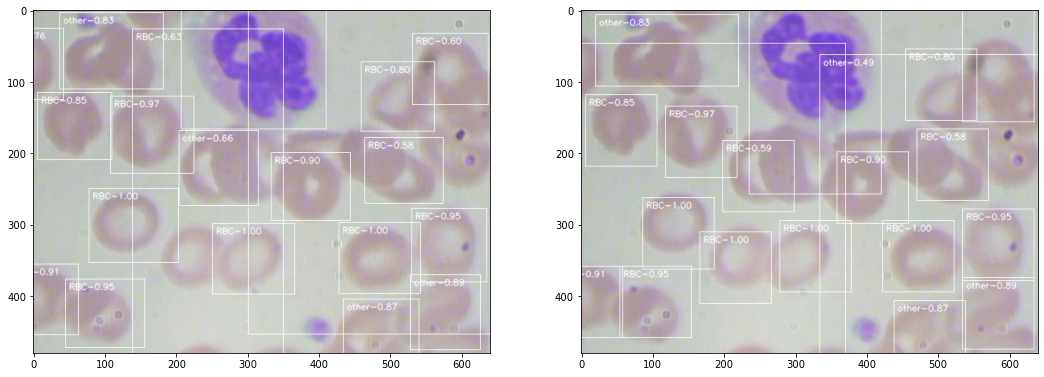

<Figure size 576x720 with 0 Axes>

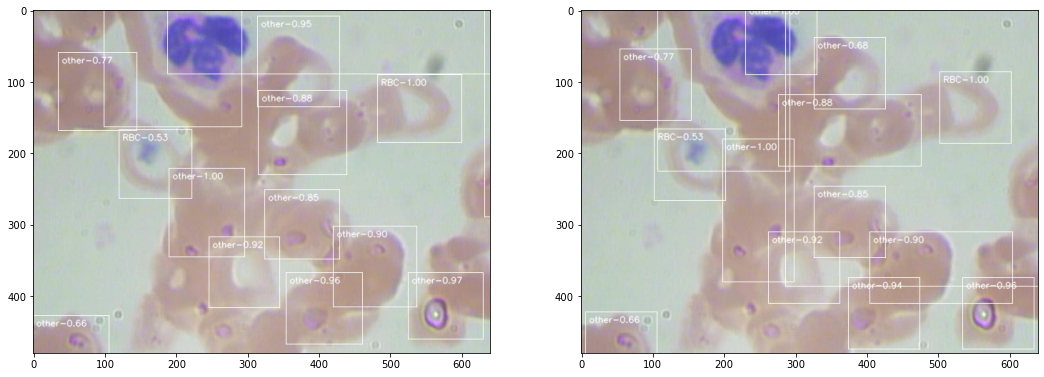

<Figure size 576x720 with 0 Axes>

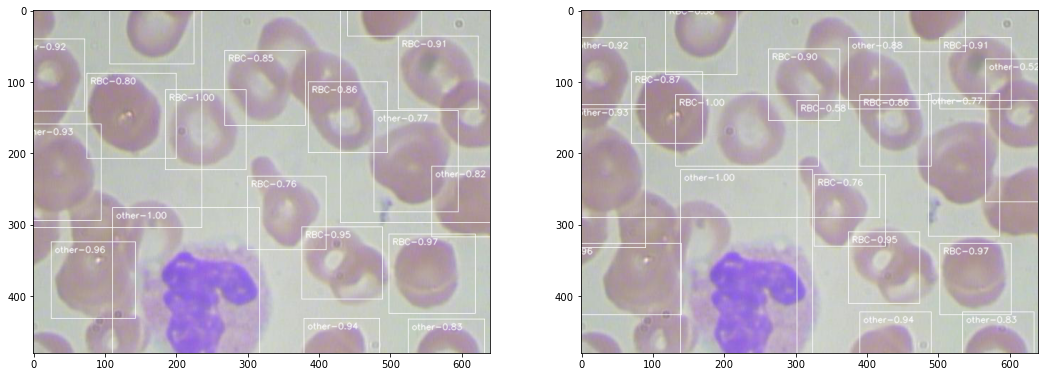

<Figure size 576x720 with 0 Axes>

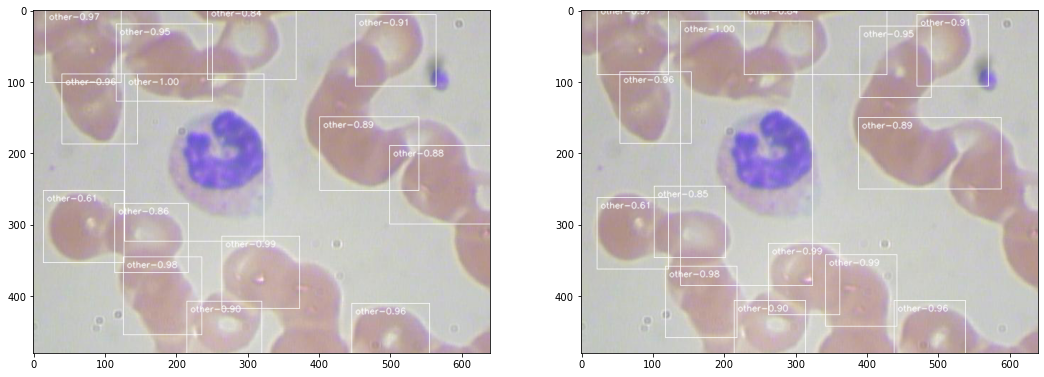

KeyboardInterrupt: 

In [36]:
EPOCHS = 10
START_EPOCH = 1

feat_opt = tf.keras.optimizers.Adam(lr=1e-4)
detection_opt = tf.keras.optimizers.Adam(lr=1e-4)

global_steps = tf.Variable(0, trainable=False, dtype=tf.int64)
writer = tf.summary.create_file_writer("./log")

cce = CategoricalCrossentropy()

for epoch in range(EPOCHS):
  batch = 0
  dataset_gen = get_img_targetScores_targetBboxes_targetMasks()
  
  for data in dataset_gen:
    batch+= 1 
    print(f"batch {batch}", end="\r")
    global_steps.assign_add(1)
    
    image_data, _, target_bboxes, target_masks, target_class_indexes = data
    
    with tf.GradientTape(persistent=True) as tape:
      features = feature_gen(image_data)
      scores_, boxes_ = RPN(features)
      # decode_output will break the computational graph, therefore RPN cannot learn anything from now on.
      boxes, scores, score_grid_anchor_mask = decode_output(boxes_, scores_)

      # feature_gen starts its computational graph here      
      pooling_feature = roi_pooling(features, boxes)
      cls_predictions, boxes_predictions = detectionLayer(pooling_feature)
      
      gt_bboxes = target_bboxes[score_grid_anchor_mask]
      gt_classes = target_class_indexes[score_grid_anchor_mask]
      gt_mask = target_masks[score_grid_anchor_mask] # either +1 or -1 or 0, +1 foreground, -1 background, 0 don't participate
      gt_computed_boxes = target_bboxes[score_grid_anchor_mask]
      
      foreground_mask = gt_mask == 1 # indicate it must be either a foreground or background
      background_mask = gt_mask == -1
      # There are plenty of boxes that are neither foreground or background.
      
      n_foreground = tf.reduce_sum(tf.cast(foreground_mask, tf.int32))
      n_background = tf.math.minimum(tf.cast(3 * tf.cast(n_foreground, tf.float32), dtype=tf.int32), tf.shape(background_mask)[0])

      foreground_gt_classes = gt_classes[foreground_mask]
      foreground_cls_predictions = cls_predictions[foreground_mask]
      foreground_gt_computed_boxes = gt_computed_boxes[foreground_mask]
      foreground_boxes_predictions = boxes_predictions[foreground_mask]     
      
      background_gt_classes = gt_classes[background_mask][0: n_background]
      background_cls_predictions = cls_predictions[background_mask][0: n_background]
      
      cls_loss = cce(foreground_gt_classes, foreground_cls_predictions)
      cls_loss += cce(background_gt_classes, background_cls_predictions)

      boxes_loss = tf.math.abs(foreground_gt_computed_boxes - foreground_boxes_predictions)
      boxes_loss = 0.5 * tf.math.pow(boxes_loss, 2) * tf.cast(boxes_loss<1, tf.float32) + (boxes_loss - 0.5) * tf.cast(boxes_loss >=1, tf.float32)
      boxes_loss = tf.reduce_sum(boxes_loss, axis=-1)
      boxes_loss = tf.reduce_mean(boxes_loss)

      total_loss = cls_loss + boxes_loss
    
    grad_detection = tape.gradient(total_loss, detectionLayer.trainable_variables)
    detection_opt.apply_gradients(zip(grad_detection, detectionLayer.trainable_variables))
    
    # writing summary data
    with writer.as_default():
      tf.summary.scalar("total_loss", total_loss, step=global_steps)
      tf.summary.scalar("cls_loss", cls_loss, step=global_steps)
      
    writer.flush()
    
    if (batch % 30) == 0:
      print("=> epoch %d  batch %d  total_loss: %.6f  cls_loss: %.6f  boxes_loss: %.6f" %(epoch+START_EPOCH, batch+1, total_loss.numpy(), cls_loss.numpy(), boxes_loss.numpy()), end="\r")
      view_sample_result(with_classifcation=True)
    if batch == 360:
      detectionLayer.save_weights(f"detectionLayer_epoch_{epoch+START_EPOCH}_{batch}.h5")

In [32]:
tf.reduce_sum(tf.math.abs(foreground_gt_computed_boxes - foreground_boxes_predictions), axis=-1)

<tf.Tensor: shape=(89,), dtype=float32, numpy=
array([1.044915  , 0.99905634, 1.2510233 , 1.1818569 , 1.2187206 ,
       0.79993   , 1.3443778 , 1.0330868 , 0.8972688 , 1.1201202 ,
       1.0630128 , 1.4357488 , 1.153103  , 1.2855406 , 1.1270685 ,
       1.2481112 , 1.1964304 , 1.4846883 , 1.2837291 , 1.3530129 ,
       1.3909867 , 1.5717285 , 1.3791531 , 1.0275325 , 0.9328316 ,
       1.3358421 , 1.1012511 , 1.1999772 , 1.0606543 , 1.5304581 ,
       1.2311467 , 1.3478549 , 1.253922  , 1.6068985 , 1.3669429 ,
       1.5528858 , 0.5743172 , 1.4936326 , 0.61494   , 1.4265641 ,
       0.78891474, 1.3985033 , 1.4602385 , 1.6669853 , 0.75565666,
       0.8051215 , 1.6724522 , 1.0236923 , 1.1193786 , 1.7975726 ,
       0.8900681 , 1.7199665 , 0.96067584, 1.6083874 , 1.1141052 ,
       1.5412614 , 1.4887463 , 0.9003695 , 0.9900365 , 1.2496811 ,
       1.9491447 , 1.0530181 , 1.8270183 , 1.08009   , 1.8271958 ,
       1.1894698 , 1.7404897 , 1.4551399 , 1.6335828 , 1.6242062 ,
       0.892900

In [32]:
foreground_boxes_predictions.shape

TensorShape([184, 4])

In [27]:
boxes_loss

NameError: name 'boxes_loss' is not defined

# Code Investigation

In [ ]:
# # features = feature_gen(image_data)
# # scores_, boxes_ = RPN(features)
# # boxes, scores, score_grid_anchor_mask = decode_output(boxes_, scores_)
# # image_width = 640
# # image_height = 480
# # cls_predictions = roi_pooling(
# #   features, 
# #   np.array([[0.2*image_width,0.6*image_height, 0.5*image_width, 1*image_height]]).astype("float32"))

# temp_img_ = tf.cast(tf.convert_to_tensor([temp_img]), dtype=tf.float32)

# pooling_feature_map = tf.image.crop_and_resize(
#     temp_img_,
#     [[0.6,0.2,1.,0.5]],
#     [0],
#     (int(0.5*image_height),int(0.4*image_width))
# )

# plt.subplot(121)
# plt.imshow((temp_img_.numpy()[0]*255).astype("int32"))
# plt.subplot(122)
# plt.imshow((pooling_feature_map.numpy()[0]*255).astype("int32"))


# 0.6,0.2,1.,0.5



# 0.2, 0.6, 0.5, 1

In [ ]:
data_gen = get_img_targetScores_targetBboxes_targetMasks()

In [ ]:
image_data, target_fgbg_scores, target_bboxes, target_fgbg_masks, target_class_indexes = next(data_gen)

In [ ]:
U = tf.random.normal((4,4,4), 0, 1)

In [ ]:
B = U > 0.5

In [ ]:
B

In [ ]:
I = 
I[2]

In [ ]:
def turn_mask_into_indexes(mask):
  zipped_indexes = tf.experimental.numpy.nonzero(mask)
  n_dim = len(zipped_indexes)
  n_coordinates = len(zipped_indexes[0])
  
  return [[int(zipped_indexes[d][idx]) for d in range(n_dim)] for idx in range(n_coordinates)]

In [ ]:
I = turn_mask_into_indexes(U > 0.5)
for i in I:
  print(U[i])

In [ ]:
I_0

In [ ]:
U[I_0]